#  **Speech Emotion Recognition (SER) using  Diffusion Modeling**




#  Business Understanding

<p style="font-size:16px; line-height:1.8">
Understanding emotions from speech is a key challenge in building intelligent systems that interact with humans in a natural way. However, existing speech emotion recognition models often fail to detect emotions clearly due to the <b style="color:#e91e63;">limited quality</b> and <b style="color:#e91e63;">expressiveness</b> of available audio data.
</p>

<p style="font-size:16px; line-height:1.8">
This project aims to improve the <b style="color:#e91e63;">clarity</b> and <b style="color:#e91e63;">richness</b> of emotional speech data using a modern generative technique called <b style="color:#e91e63;">diffusion modeling</b>. By enhancing existing audio samples from two benchmark datasets — <b style="color:#e91e63;">EmoDB</b> (German) and <b style="color:#e91e63;">RAVDESS</b> (English) — and converting them into <b style="color:#e91e63;">mel-spectrograms</b>, we generate new data with <b style="color:#e91e63;">clearer emotional signals</b>.
</p>

<p style="font-size:16px; line-height:1.8">
These enhanced spectrograms will be used to train a <b style="color:#e91e63;">ResNet-based emotion recognition model</b>, and we will compare its performance before and after augmentation using key metrics like <b style="color:#e91e63;">accuracy</b>, <b style="color:#e91e63;">F1-score</b>, and <b style="color:#e91e63;">confusion matrices</b>.
</p>

<p style="font-size:16px; line-height:1.8">
The goal is to demonstrate how <b style="color:#e91e63;">advanced data generation techniques</b> can boost the performance of deep learning models in <b style="color:#e91e63;">speech emotion recognition</b>, making AI systems more <b style="color:#e91e63;">expressive</b>, <b style="color:#e91e63;">accurate</b>, and <b style="color:#e91e63;">human-like</b>.
</p>


In [ ]:
!pip install --q librosa
!pip install --q mealpy

import pandas as pd
import numpy as np

import os
import sys
import tensorflow as tf
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Bidirectional, LSTM, Dense, Attention, Add, Flatten

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 54.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/emotion_data/EmoDB.zip' -d '/content/emotion_data'

Archive:  /content/drive/MyDrive/emotion_data/EmoDB.zip
  inflating: /content/emotion_data/wav/03a01Fa.wav  
  inflating: /content/emotion_data/wav/03a01Nc.wav  
  inflating: /content/emotion_data/wav/03a01Wa.wav  
  inflating: /content/emotion_data/wav/03a02Fc.wav  
  inflating: /content/emotion_data/wav/03a02Nc.wav  
  inflating: /content/emotion_data/wav/03a02Ta.wav  
  inflating: /content/emotion_data/wav/03a02Wb.wav  
  inflating: /content/emotion_data/wav/03a02Wc.wav  
  inflating: /content/emotion_data/wav/03a04Ad.wav  
  inflating: /content/emotion_data/wav/03a04Fd.wav  
  inflating: /content/emotion_data/wav/03a04Lc.wav  
  inflating: /content/emotion_data/wav/03a04Nc.wav  
  inflating: /content/emotion_data/wav/03a04Ta.wav  
  inflating: /content/emotion_data/wav/03a04Wc.wav  
  inflating: /content/emotion_data/wav/03a05Aa.wav  
  inflating: /content/emotion_data/wav/03a05Fc.wav  
  inflating: /content/emotion_data/wav/03a05Nd.wav  
  inflating: /content/emotion_data/wav/03a0

In [ ]:
# Install 7zip if not already available
!sudo apt install p7zip-full -y

# Extract using 7z (more robust than unzip)
!7z x '/content/drive/MyDrive/emotion_data/RAVDESS.zip' -o'/content/emotion_data/'y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/emotion_data/                                              1 file, 450102890 bytes (430 MiB)

Extracting archive: /content/drive/MyDrive/emotion_data/RAVDESS.zip
--
Path = /content/drive/MyDrive/emotion_data/RAVDESS.zip
Type = zip
Physical Size = 450102890

  0%      1% 45 - Actor_01/03-01-07-01-01-02-01.wav                                           

In [ ]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip -O RAVDESS.zip
import zipfile # Import the zipfile module
with zipfile.ZipFile("RAVDESS.zip", 'r') as zip_ref:
    zip_ref.extractall("RAVDESS")

--2025-05-15 23:25:41--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1188976/files/Audio_Speech_Actors_01-24.zip [following]
--2025-05-15 23:25:42--  https://zenodo.org/records/1188976/files/Audio_Speech_Actors_01-24.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘RAVDESS.zip’

RAVDESS.zip         100%[===================>] 198.81M  21.5MB/s    in 11s     

2025-05-15 23:25:53 (18.3 MB/s) - ‘RAVDESS.zip’ saved [208468073/208468073]



# **Data understanding**

In [ ]:
import os

# 📁 Set correct directories
emodb_dir = "/content/emotion_data/wav"
ravdess_dir = "/content/emotion_data/y"  # because you extracted to "y" by mistake

# 🎙️ EmoDB: only .wav files
emodb_wavs = []
for root, _, files in os.walk(emodb_dir):
    for f in files:
        if f.endswith(".wav"):
            emodb_wavs.append(os.path.join(root, f))

# 🎧 RAVDESS: only .wav files
ravdess_wavs = []
for root, _, files in os.walk(ravdess_dir):
    for f in files:
        if f.endswith(".wav"):
            ravdess_wavs.append(os.path.join(root, f))

# 📊 Print results
print(f"🎙️ EmoDB WAV files found: {len(emodb_wavs)}")
print(f"🎧 RAVDESS WAV files found: {len(ravdess_wavs)}")


🎙️ EmoDB WAV files found: 535
🎧 RAVDESS WAV files found: 2880


##  Preview Random Audio Samples from Both Datasets

In [ ]:
import IPython.display as ipd
import random
import os

# ⚠️ Make sure emodb_wavs and ravdess_wavs are already defined!
# If not, re-run the loading code from earlier.

# 🎙️ Preview a random EmoDB sample
if emodb_wavs:
    sample_emodb = random.choice(emodb_wavs)
    print("🎙️ EmoDB Sample:", os.path.basename(sample_emodb))
    ipd.display(ipd.Audio(filename=sample_emodb))
else:
    print("⚠️ No EmoDB .wav files found.")

# 🎧 Preview a random RAVDESS sample
if ravdess_wavs:
    sample_ravdess = random.choice(ravdess_wavs)
    print("🎧 RAVDESS Sample:", os.path.basename(sample_ravdess))
    ipd.display(ipd.Audio(filename=sample_ravdess))
else:
    print("⚠️ No RAVDESS .wav files found.")


🎙️ EmoDB Sample: 08b01Lb.wav


🎧 RAVDESS Sample: 03-01-08-02-02-01-15.wav


<h2 style="color:#27ae60;"> Emotion Distribution in emoDB</h2>

Emotion Counts:
neutral: 79
disgust: 46
fear: 69
sadness: 62
happiness: 71
anger: 127
boredom: 81


<ipython-input-5-a162894a7b2a>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_order, y=counts, palette="colorblind")


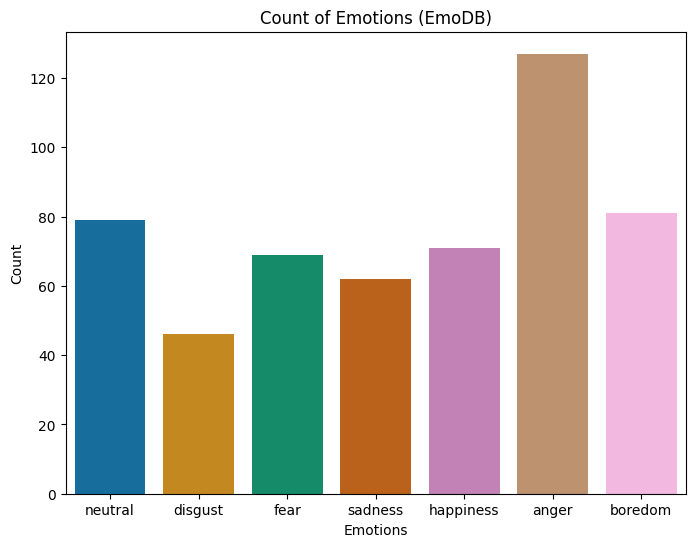

In [ ]:
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

emodb_path = '/content/emotion_data/wav/*.wav'

# Mapping EmoDB filename encoding to emotions
emotion_map = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}
# Extract emotion labels from filenames
filenames = glob.glob(emodb_path)
emotions = [emotion_map[os.path.basename(f)[5]] for f in filenames if os.path.basename(f)[5] in emotion_map]

# Count occurrences of each emotion
emotion_counts = Counter(emotions)

# Sort emotions by predefined order
emotion_order = ['neutral', 'disgust', 'fear', 'sadness', 'happiness', 'anger', 'boredom']
counts = [emotion_counts[e] for e in emotion_order if e in emotion_counts]

# Print the count of each emotion
print("Emotion Counts:")
for emotion in emotion_order:
    count = emotion_counts.get(emotion, 0)  # Get the count or default to 0 if emotion is not found
    print(f"{emotion}: {count}")

# Plot the emotion distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=emotion_order, y=counts, palette="colorblind")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Count of Emotions (EmoDB)")
plt.show()

In [ ]:
Emo_df = pd.DataFrame({
    'filenames': filenames,
    'emotions': emotions
})
Emo_df.head()

filenames   emotions
0  /content/emotion_data/wav/10b03Wb.wav      anger
1  /content/emotion_data/wav/16b02Aa.wav       fear
2  /content/emotion_data/wav/09b09Wa.wav      anger
3  /content/emotion_data/wav/09a05Wc.wav      anger
4  /content/emotion_data/wav/08a05Fe.wav  happiness

<h2 style="color:#9b59b6;"> Emotion Count per Class with Labels and Percentage</h2>

In [ ]:
import os
import pandas as pd

# -----------------------------
# Step 1: Define emotion mapping
# -----------------------------
emodb_map = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

# -----------------------------
# Step 2: Extract emotion code from filename
# -----------------------------
def extract_emodb_emotion(path):
    filename = os.path.basename(path)
    if len(filename) >= 6:
        code = filename[5]  # 6th character
        return emodb_map.get(code, "unknown")
    return "invalid"

# -----------------------------
# Step 3: Extract emotion labels
# -----------------------------
emodb_emotions = [extract_emodb_emotion(f) for f in emodb_wavs]

# -----------------------------
# Step 4: Create DataFrame
# -----------------------------
emodb_df = pd.DataFrame({'File': emodb_wavs, 'Emotion': emodb_emotions})

# -----------------------------
# Step 5: Count and percentage
# -----------------------------
emotion_counts = emodb_df['Emotion'].value_counts().sort_values(ascending=False)
emotion_percents = round((emotion_counts / len(emodb_df)) * 100, 1)

# -----------------------------
# Step 6: Summary DataFrame
# -----------------------------
emotion_summary = pd.DataFrame({
    'Emotion': emotion_counts.index,
    'Count': emotion_counts.values,
    'Percent (%)': emotion_percents.values
})

# -----------------------------
# Step 7: Display styled table
# -----------------------------
emotion_summary_styled = emotion_summary.style.set_properties(**{
    'background-color': '#fdf5f9',
    'color': '#2c3e50',
    'border-color': '#ba68c8',
    'text-align': 'center'
}).set_table_styles([
    {
        'selector': 'th',
        'props': [('background-color', '#ba68c8'),
                  ('color', 'white'),
                  ('font-weight', 'bold'),
                  ('text-align', 'center')]
    }
]).set_caption("🎙️ <b style='color:#ba68c8;'>EmoDB Emotion Summary</b>")

# -----------------------------
# Step 8: Show it
# -----------------------------
emotion_summary_styled


<h2 style="color:#9c27b0;"> Waveform Visualization for a Random EmoDB Sample</h2>

<ipython-input-18-153ffb0b0e7a>:20: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


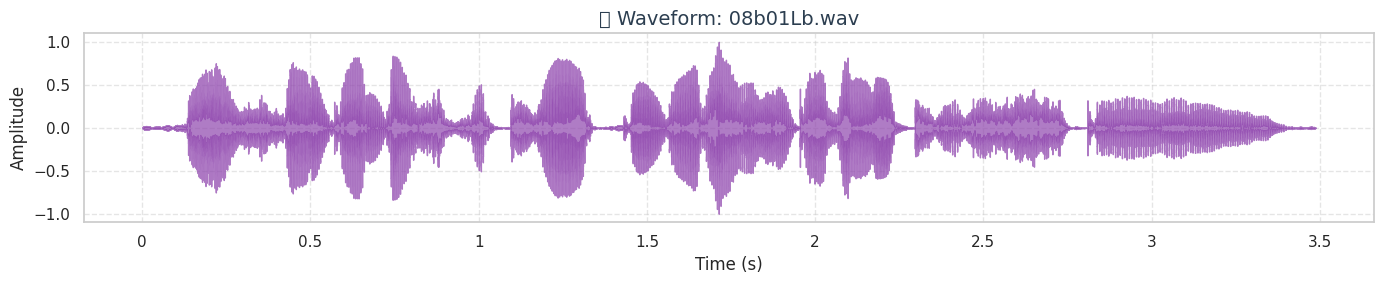

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# ✅ Check if the sample exists
if not os.path.exists(sample_emodb):
    print("⚠️ The selected EmoDB sample does not exist. Please re-run the sample selection step.")
else:
    # 🎧 Load the audio sample
    y, sr = librosa.load(sample_emodb, sr=None, mono=True)

    # 🎨 Plot the waveform
    plt.figure(figsize=(14, 3))
    librosa.display.waveshow(y, sr=sr, alpha=0.7, color='#8e44ad')
    plt.title(f"🎵 Waveform: {os.path.basename(sample_emodb)}", fontsize=14, color='#2c3e50')
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


<h2 style="color:#8e44ad;"> Pitch Contour (F0) Over Time</h2>

<ipython-input-19-1b3092469d51>:33: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


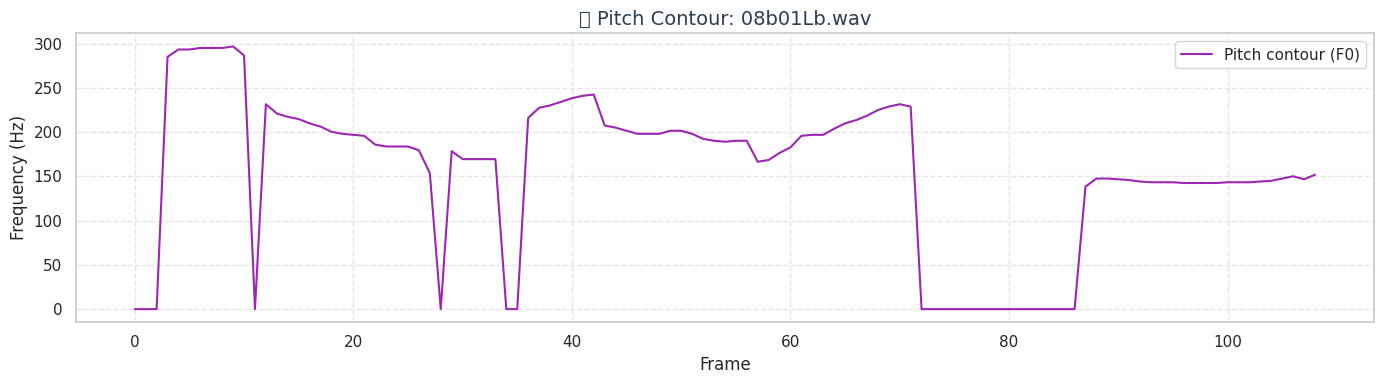

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np

# ✅ Check sample existence
if not os.path.exists(sample_emodb):
    print("⚠️ EmoDB sample not found. Please verify the file path.")
else:
    # 🎧 Load audio
    y, sr = librosa.load(sample_emodb, sr=None, mono=True)

    # 🎼 Estimate pitch using librosa.pyin (with frame-level pitch tracking)
    f0, voiced_flag, voiced_probs = librosa.pyin(
        y,
        sr=sr,
        fmin=librosa.note_to_hz('C2'),
        fmax=librosa.note_to_hz('C7')
    )

    # 🧹 Replace unvoiced (NaN) with 0 for plotting clarity (optional)
    f0_clean = np.where(np.isnan(f0), 0, f0)

    # 🎨 Plot pitch contour
    plt.figure(figsize=(14, 4))
    plt.plot(f0_clean, color="#9c27b0", label="Pitch contour (F0)")
    plt.title(f"🎼 Pitch Contour: {os.path.basename(sample_emodb)}", fontsize=14, color="#2c3e50")
    plt.xlabel("Frame")
    plt.ylabel("Frequency (Hz)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


<h2 style="color:#27ae60;"> Emotion Distribution in RAVDESS</h2>

Emotion Counts:
neutral: 96
calm: 192
happy: 192
sad: 192
angry: 192
fearful: 192
disgust: 192
surprised: 192


<ipython-input-8-974b87c584af>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_order, y=counts, palette="colorblind")


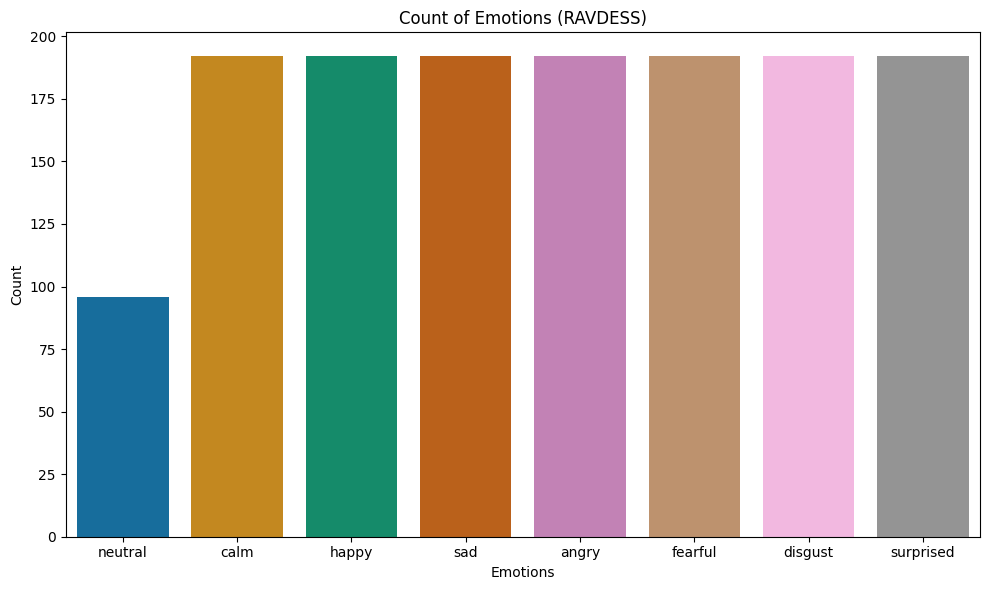

In [ ]:


ravdess_path = "/content/RAVDESS/Actor_*/*.wav"
# Mapping RAVDESS numeric encoding t#  <center> 🇩🇪 EmoDB </center>o emotions
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

# Extract emotion labels from filenames
filenames = glob.glob(ravdess_path, recursive=True)
emotions = [emotion_map[os.path.basename(f).split('-')[2]] for f in filenames if os.path.basename(f).split('-')[2] in emotion_map]

# Count occurrences of each emotion
emotion_counts = Counter(emotions)

# Sort emotions by predefined order
emotion_order = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
counts = [emotion_counts[e] for e in emotion_order if e in emotion_counts]

# Print the count of each emotion
print("Emotion Counts:")
for emotion in emotion_order:
    count = emotion_counts.get(emotion, 0)  # Get the count or default to 0 if emotion is not found
    print(f"{emotion}: {count}")

# Plot the emotion distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_order, y=counts, palette="colorblind")
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Count of Emotions (RAVDESS)")  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
Ravdess_df = pd.DataFrame({
    'filenames': filenames,
    'emotions': emotions
})
Ravdess_df.head()

filenames emotions
0  /content/RAVDESS/Actor_10/03-01-07-01-01-01-10...  disgust
1  /content/RAVDESS/Actor_10/03-01-04-01-02-02-10...      sad
2  /content/RAVDESS/Actor_10/03-01-05-01-02-01-10...    angry
3  /content/RAVDESS/Actor_10/03-01-05-01-01-01-10...    angry
4  /content/RAVDESS/Actor_10/03-01-03-02-02-02-10...    happy

<h2 style="color:#8e44ad;"> Duration of Random Samples RAVDESS</h2>

<ipython-input-15-1a78d92fa2ef>:38: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


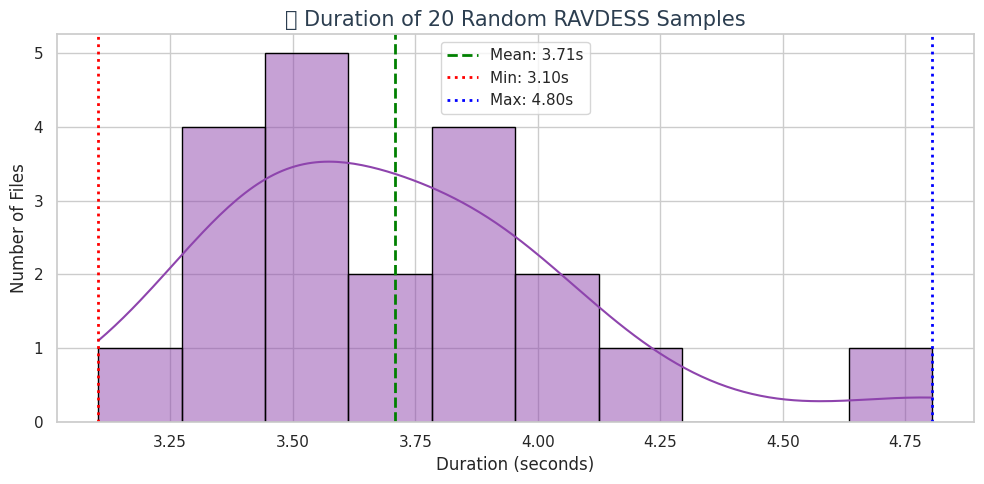

In [ ]:
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

# Set Seaborn style
sns.set(style="whitegrid")

# Make sure ravdess_wavs is defined and non-empty
if not ravdess_wavs:
    print("⚠️ No RAVDESS files loaded. Please check the path.")
else:
    # Load durations from 20 random RAVDESS files
    durations = []
    for f in random.sample(ravdess_wavs, 20):
        if os.path.exists(f):
            y, sr = librosa.load(f, sr=None, mono=True)
            durations.append(len(y) / sr)

    durations = np.array(durations)

    # Plot duration distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(durations, bins=10, color="#8e44ad", edgecolor="black", kde=True)

    # Mean, min, max lines
    plt.axvline(durations.mean(), color='green', linestyle='--', linewidth=2, label=f"Mean: {durations.mean():.2f}s")
    plt.axvline(durations.min(), color='red', linestyle=':', linewidth=2, label=f"Min: {durations.min():.2f}s")
    plt.axvline(durations.max(), color='blue', linestyle=':', linewidth=2, label=f"Max: {durations.max():.2f}s")

    # Labels and titles
    plt.title("⏱️ Duration of 20 Random RAVDESS Samples", fontsize=15, color="#2c3e50")
    plt.xlabel("Duration (seconds)", fontsize=12)
    plt.ylabel("Number of Files", fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()


<h2 style="color:#d81b60;"> Mel-Spectrogram Visualization</h2>

<ipython-input-16-79c6e63c626e>:25: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


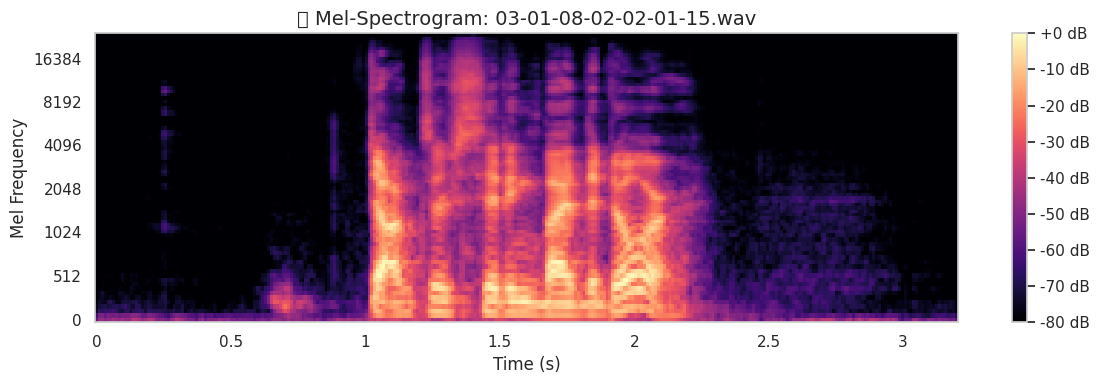

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

# ✅ Ensure sample_ravdess exists and points to a valid file
if not os.path.exists(sample_ravdess):
    print("⚠️ The selected RAVDESS sample does not exist. Please re-run the selection step.")
else:
    # 🎧 Load audio
    y, sr = librosa.load(sample_ravdess, sr=None, mono=True)

    # 🎼 Compute mel-spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=80)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # 🎨 Plot
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(mel_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"🎨 Mel-Spectrogram: {os.path.basename(sample_ravdess)}", fontsize=14)
    plt.xlabel("Time (s)")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()


# Merge of RAVDESS & EmoDB Datasets

In [ ]:
data_path = pd.concat([Ravdess_df,Emo_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)

data_path.head()

filenames emotions
0  /content/RAVDESS/Actor_10/03-01-07-01-01-01-10...  disgust
1  /content/RAVDESS/Actor_10/03-01-04-01-02-02-10...      sad
2  /content/RAVDESS/Actor_10/03-01-05-01-02-01-10...    angry
3  /content/RAVDESS/Actor_10/03-01-05-01-01-01-10...    angry
4  /content/RAVDESS/Actor_10/03-01-03-02-02-02-10...    happy

In [ ]:
data_path.reset_index(drop=True)

filenames   emotions
0     /content/RAVDESS/Actor_10/03-01-07-01-01-01-10...    disgust
1     /content/RAVDESS/Actor_10/03-01-04-01-02-02-10...        sad
2     /content/RAVDESS/Actor_10/03-01-05-01-02-01-10...      angry
3     /content/RAVDESS/Actor_10/03-01-05-01-01-01-10...      angry
4     /content/RAVDESS/Actor_10/03-01-03-02-02-02-10...      happy
...                                                 ...        ...
1970              /content/emotion_data/wav/13b01Fc.wav  happiness
1971              /content/emotion_data/wav/14b02Wb.wav      anger
1972              /content/emotion_data/wav/13a02Ec.wav    disgust
1973              /content/emotion_data/wav/16b10Wb.wav      anger
1974              /content/emotion_data/wav/15a04Fd.wav  happiness

[1975 rows x 2 columns]

In [ ]:
data_path = data_path[data_path["emotions"].str.contains("calm") == False]
data_path = data_path[data_path["emotions"].str.contains("boredom") == False]
data_path = data_path[data_path["emotions"].str.contains("ps") == False]
data_path = data_path[data_path["emotions"].str.contains("surprise") == False]
data_path['emotions'] = data_path['emotions'].replace({
    'anger': 'angry',
    'happiness': 'happy',
    'sadness': 'sad',
    'fearful' : 'fear'
})
data_path['emotions'].unique()

array(['disgust', 'sad', 'angry', 'happy', 'fear', 'neutral'],
      dtype=object)

<ipython-input-34-860b0c7d7774>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_path['emotions'], palette="pastel")


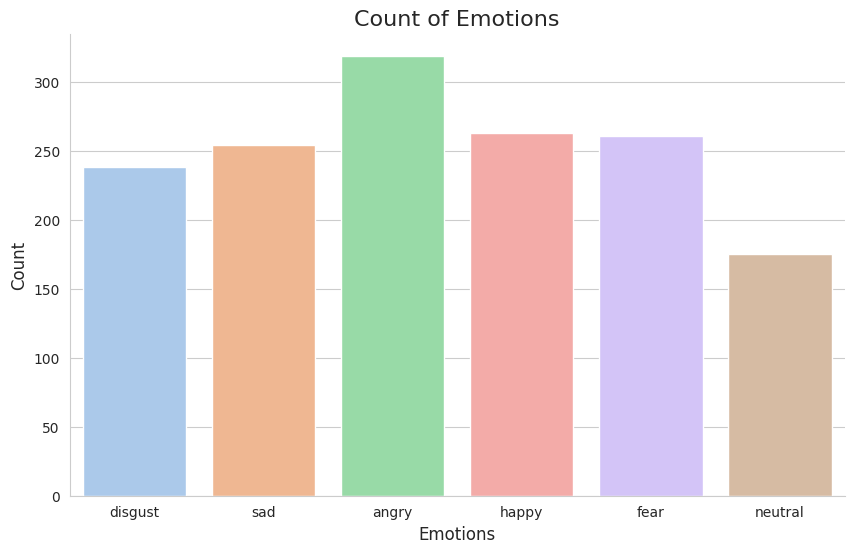

Counter({'angry': 319, 'happy': 263, 'fear': 261, 'sad': 254, 'disgust': 238, 'neutral': 175})


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import collections

# Set the visual style
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', size=16)

# Use pastel colors for bars
sns.countplot(x=data_path['emotions'], palette="pastel")

# Add axis labels
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)

# Remove unnecessary spines
sns.despine(top=True, right=True)

# Show the plot
plt.show()

# Optional: Display emotion counts
print(collections.Counter(data_path['emotions']))


# **Data preparation**

###  Audio Visualization Functions

- create_waveplot
  Plots the waveform of an audio signal for a given emotion `e`.

- create_spectrogram
  Displays the spectrogram using STFT to show frequency content over time.

- create_mfcc
  Shows the MFCCs (Mel-Frequency Cepstral Coefficients) that represent audio features for speech/emotion analysis.


In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveform for audio with emotion {}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft performs Fourier transform.
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with emotion {}'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
def create_mfcc(data, sr, e):
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plt.figure(figsize=(12, 3))
    plt.title('Mel-frequency cepstral coefficient for audio with emotion {}'.format(e), size=15)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.ylabel('MFCC')
    plt.colorbar()

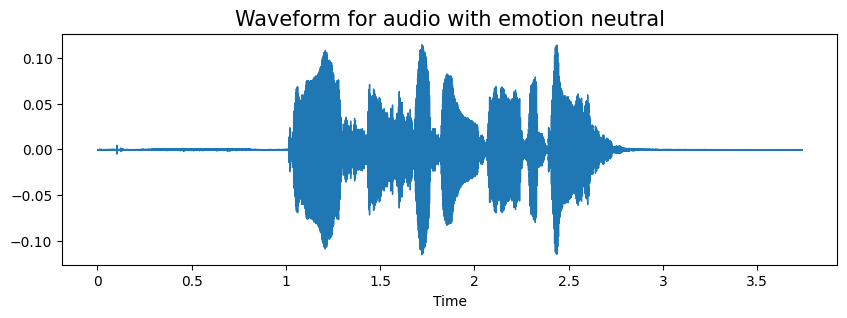

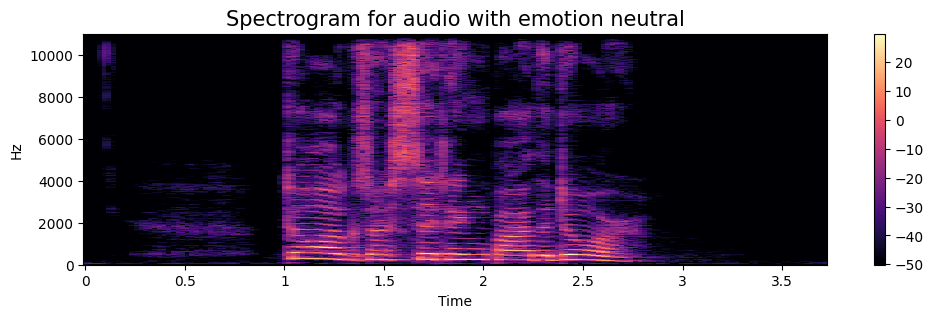

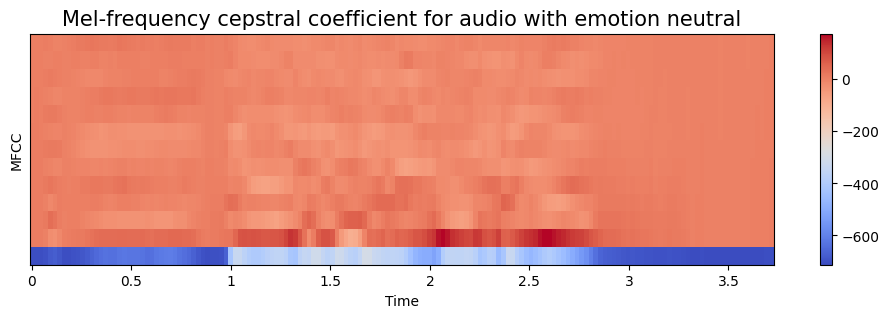

In [ ]:
emotion = 'neutral'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

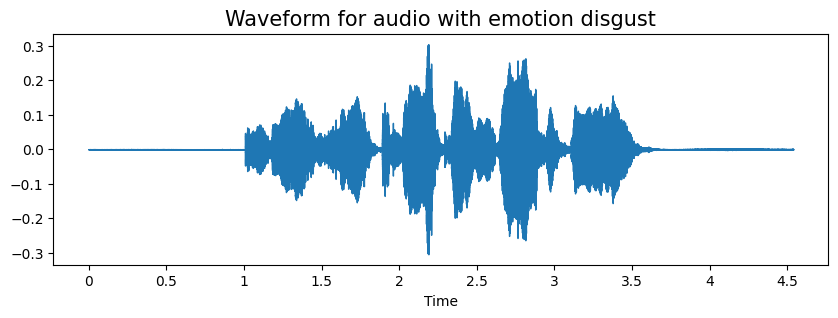

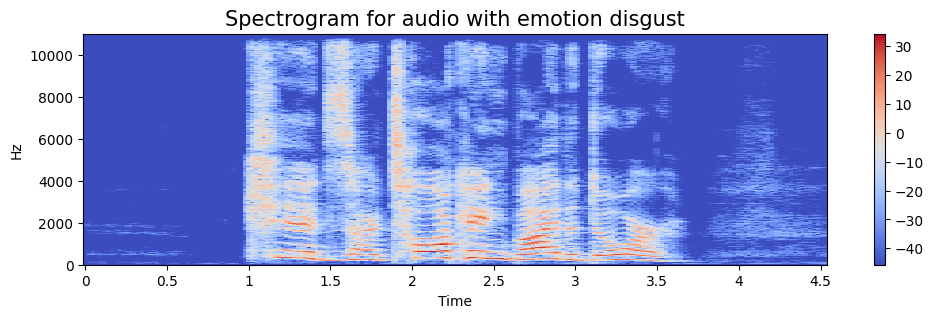

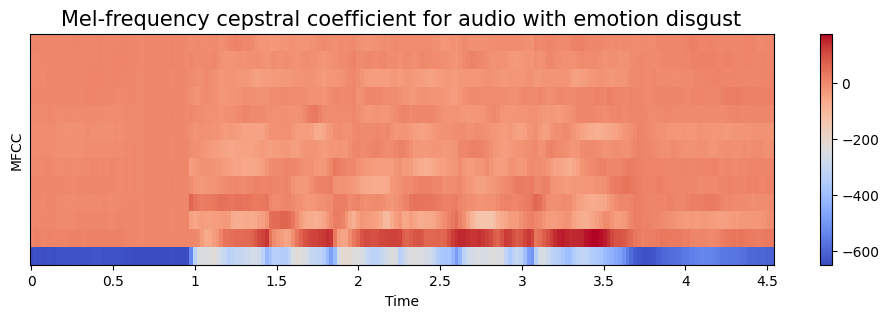

In [ ]:
emotion = 'disgust'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

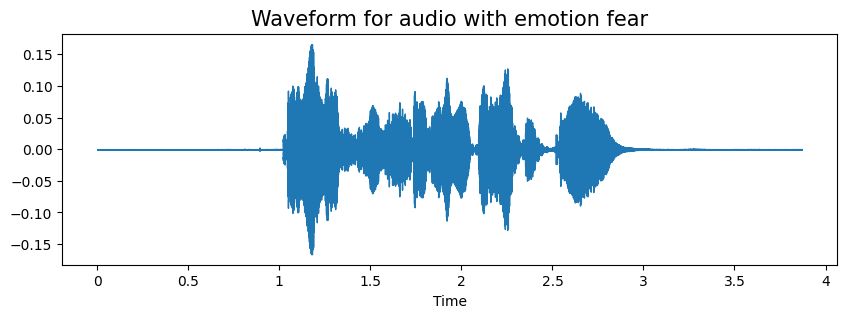

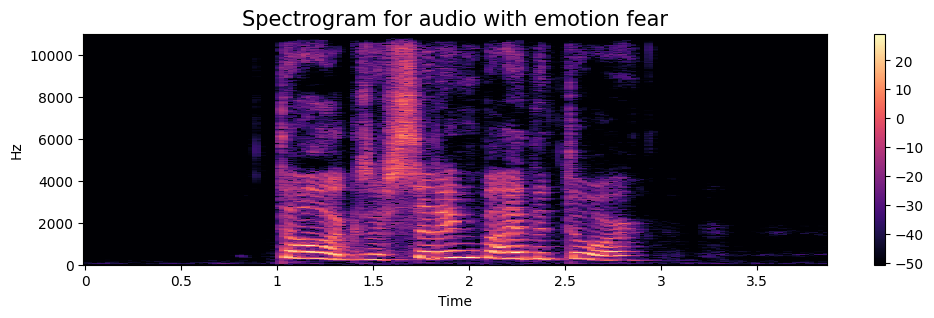

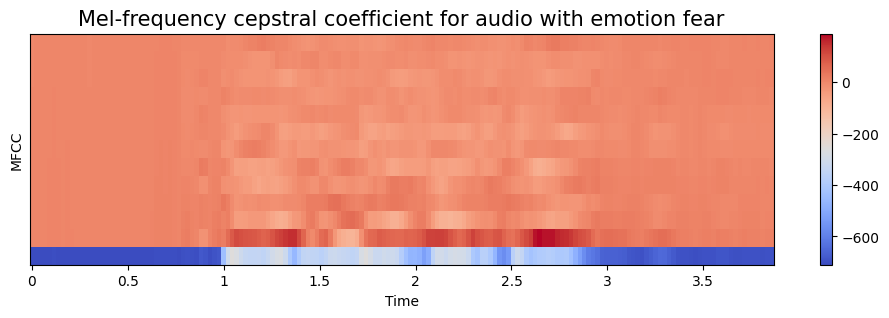

In [ ]:
emotion = 'fear'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

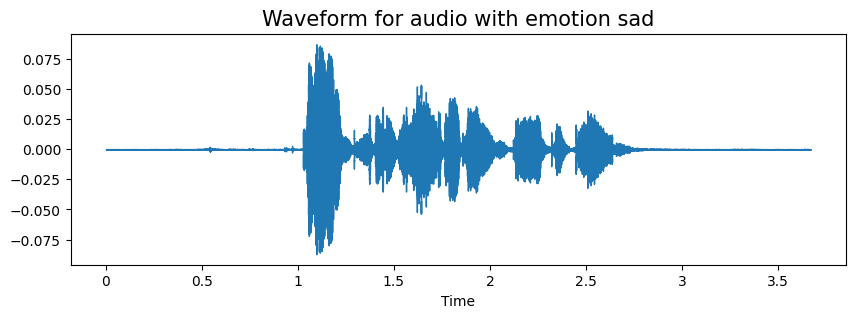

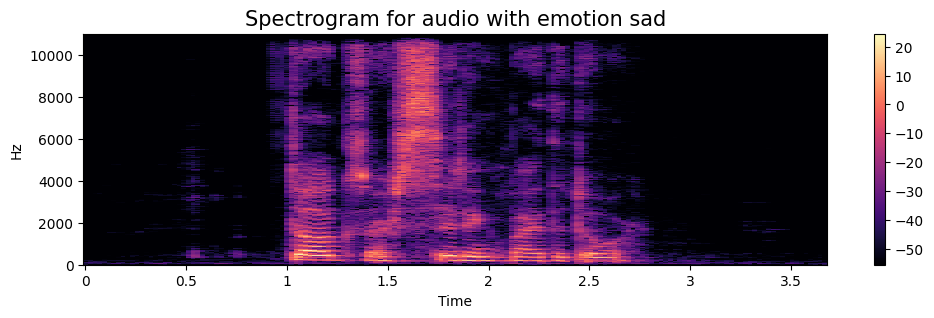

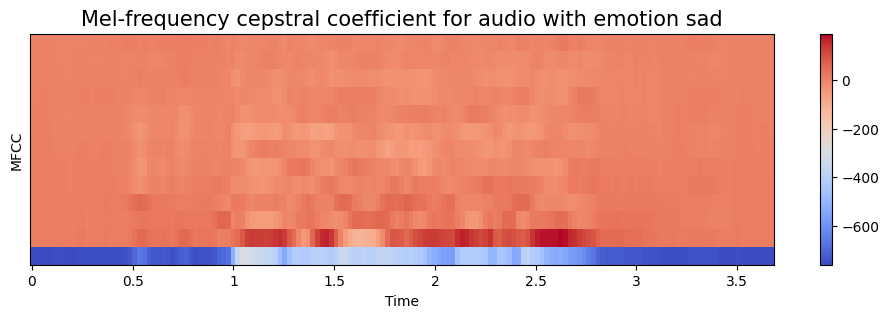

In [ ]:
emotion = 'sad'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

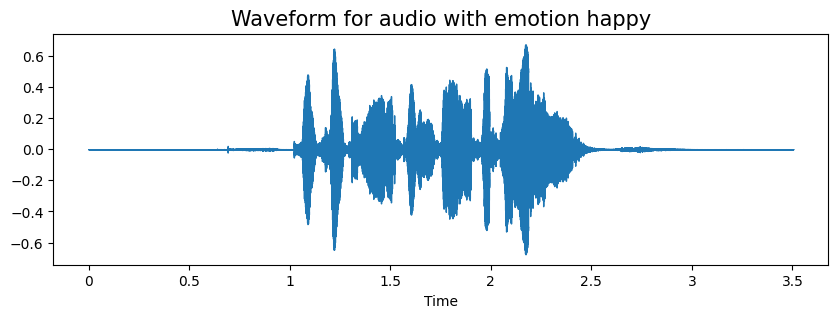

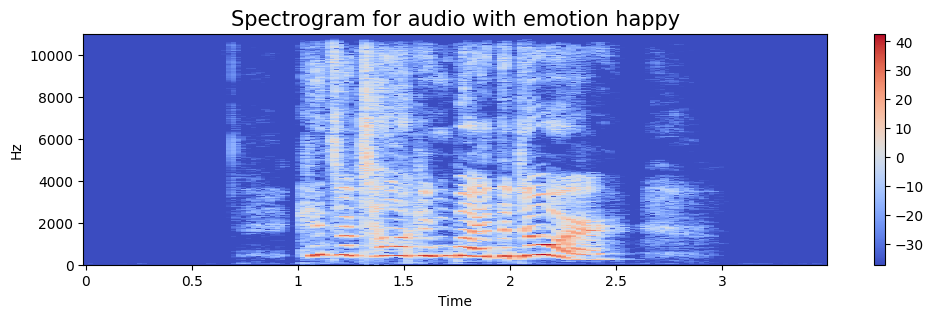

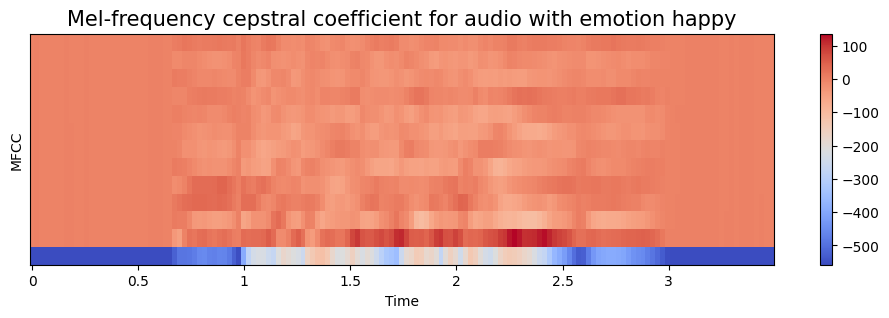

In [ ]:
emotion = 'happy'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

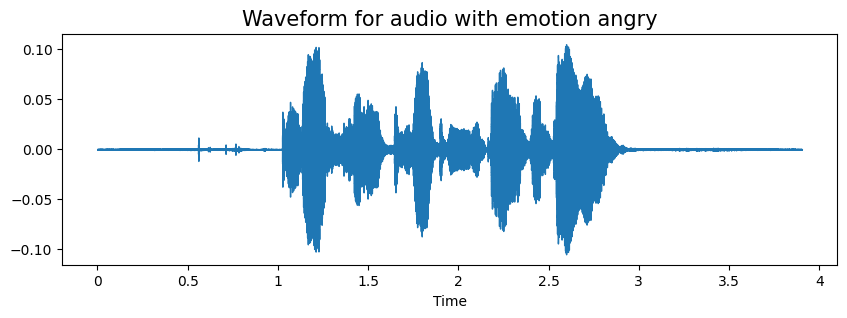

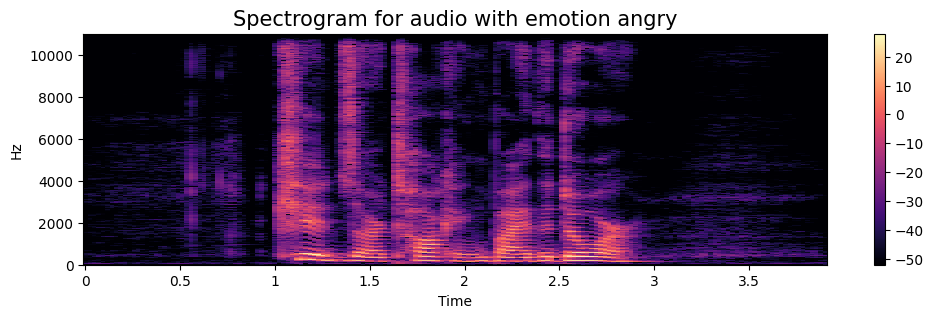

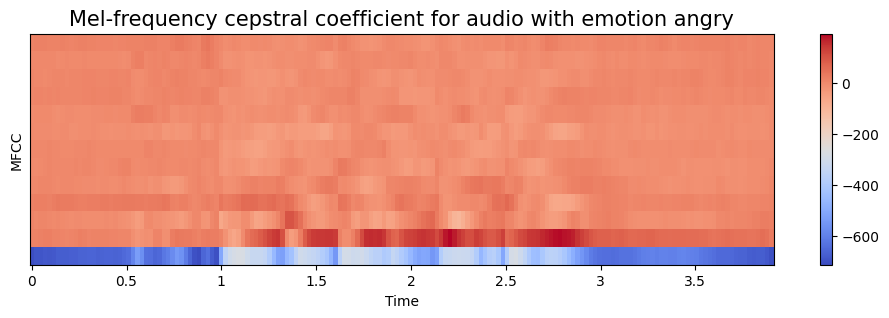

In [ ]:
emotion = 'angry'
path = np.array(data_path.filenames[data_path.emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

### Data Augmentation

These functions modify audio to improve model robustness:

- **Noise**: Adds background disturbance  
- **Stretch**: Speeds up or slows down audio  
- **Pitch Shift**: Changes the pitch without changing speed

They help generate varied versions of the same sample for better training.


In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

# Define augmentation functions
def noise(data, noise_rate=0.05):
    noise_amp = noise_rate * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.9):
    return librosa.effects.time_stretch(data, rate=rate)

def pitch_shift(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# Load an example audio file
path = np.array(data_path.filenames)[2]
data, sample_rate = librosa.load(path)

# Apply augmentations
x_stretched = stretch(data)
x_pitch_shifted = pitch_shift(data, sample_rate)

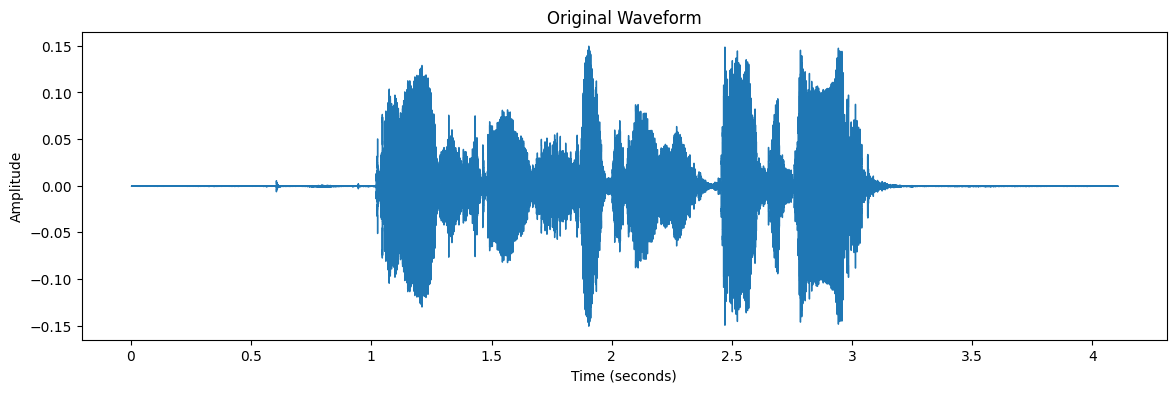

In [ ]:
# Plot the original waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Original Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

# Play the original audio
Audio(data, rate=sample_rate)

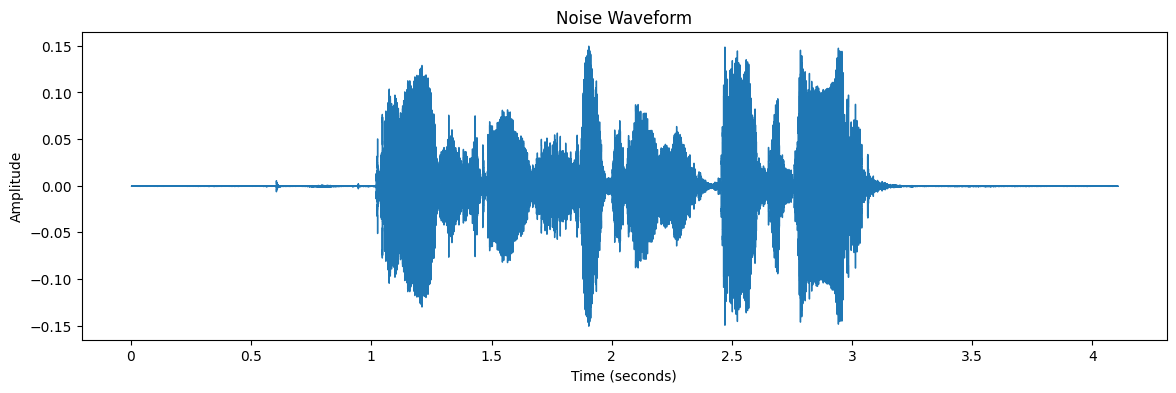

In [ ]:
x = noise(data)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Noise Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x, rate=sample_rate)

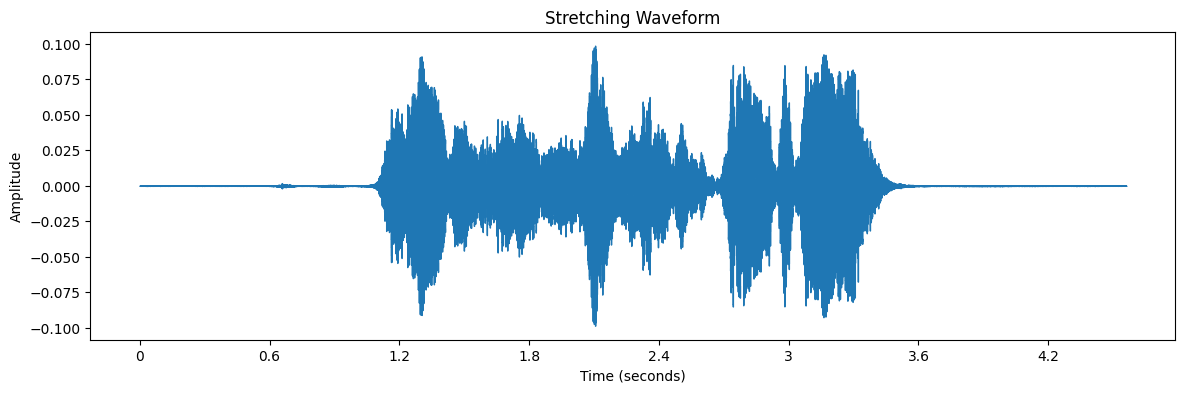

In [ ]:
x = stretch(data)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the stretched waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x_stretched, sr=sample_rate)
plt.title("Stretching Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x, rate=sample_rate)

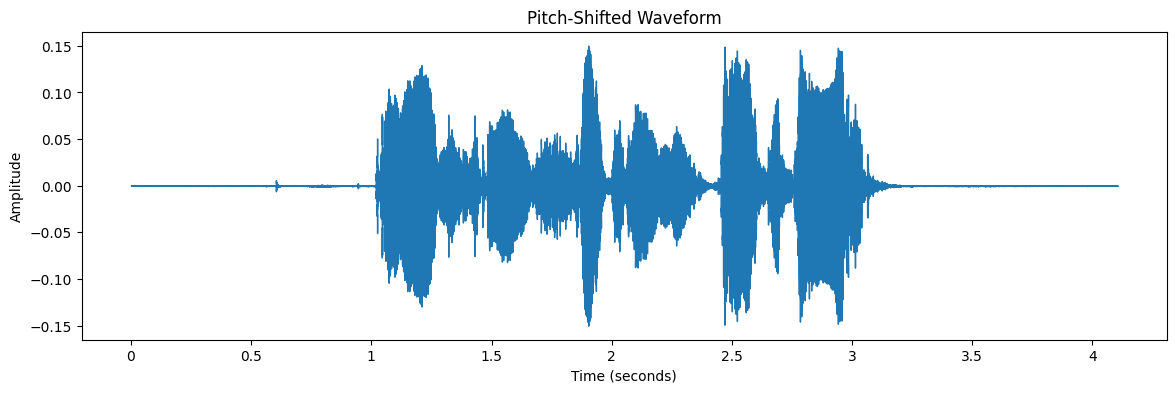

In [ ]:
x_pitch_shifted = pitch_shift(data, sample_rate)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Pitch-Shifted Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x_pitch_shifted, rate=sample_rate)

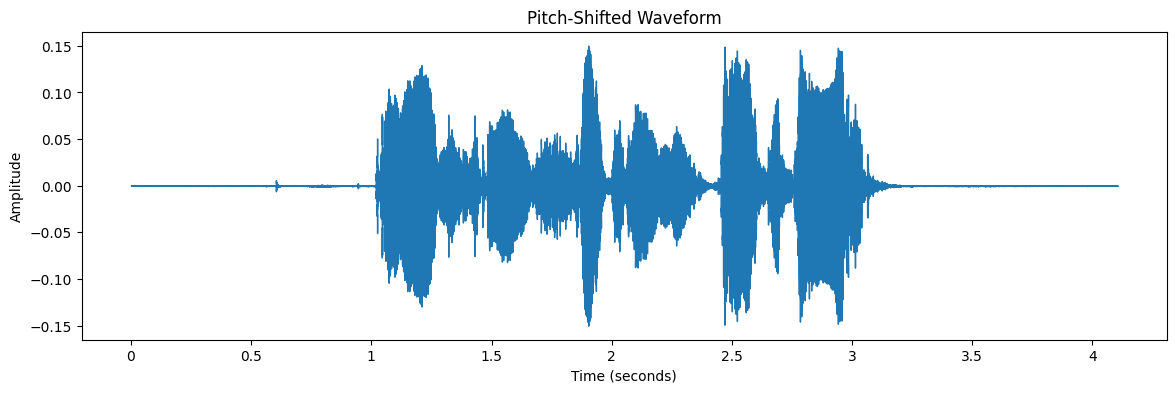

In [ ]:
x_pitch_shifted = pitch_shift(data, sample_rate)

# Load the audio file
data, sample_rate = librosa.load(path)

# Plot the waveform using waveshow
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Pitch-Shifted Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

Audio(x_pitch_shifted, rate=sample_rate)

In [ ]:
# Data augmentation function for the model
def get_features(path):
    # Load audio file
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Normal data
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # Noise data
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    # Stretched data
    stretched_data = stretch(data)
    res3 = extract_features(stretched_data, sample_rate)
    result = np.vstack((result, res3))

    # Pitch-shifted data
    pitched_data = pitch_shift(data, sample_rate)
    res4 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res4))

    # Combined pitch + noise
    pitched_noise_data = noise(pitched_data)
    res5 = extract_features(pitched_noise_data, sample_rate)
    result = np.vstack((result, res5))

    return result

###  Feature Extraction

This function extracts key audio features:

- **ZCR**: Signal frequency info  
- **RMSE**: Loudness/energy  
- **MFCC**: Voice timbre

All features are flattened and combined into one vector for the model.


In [ ]:
FIXED_LENGTH = 5120  # Adjust this based on your dataset's typical audio length

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

# RMS Energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# MFCC
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

# Extract features and stack them into a one-dimensional array
def extract_features(data, sr, frame_length=2048, hop_length=512):
    # Fix the length of the audio signal
    data = librosa.util.fix_length(data, size=FIXED_LENGTH)

    # Extract features
    zcr_feature = zcr(data, frame_length, hop_length)
    rmse_feature = rmse(data, frame_length, hop_length)
    mfcc_feature = mfcc(data, sr, frame_length, hop_length)

    # Combine features into a single vector
    result = np.hstack((zcr_feature, rmse_feature, mfcc_feature))
    return result


###   Extract Features and Labels

Loop through all audio paths and extract augmented features using `get_features()`.  
Each original sample produces multiple augmented versions, so each label is repeated accordingly.


In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.filenames, data_path.emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # Each data point will be added 4 times due to 4 augmentations (normal, noise, stretch, pitch-shift).
        Y.append(emotion)

# Extract the length of the feature matrix X and label array Y
len(X), len(Y), data_path.filenames.shape

(7550, 7550, (1510,))

###  Save Features to CSV

Convert the feature list to a DataFrame and add emotion labels.  
Save the full dataset to `features.csv` for future use.


In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
print(Features.head(10))

Features = pd.read_csv('features.csv')
print(Features.shape)

          0         1         2         3         4         5         6  \
0  0.037109  0.080078  0.140625  0.171387  0.226074  0.244629  0.251953   
1  0.239258  0.353516  0.476562  0.491699  0.503418  0.509766  0.520508   
2  0.038086  0.060547  0.122070  0.149902  0.175293  0.195312  0.192383   
3  0.037109  0.066406  0.123047  0.151367  0.190430  0.205566  0.198242   
4  0.259277  0.381836  0.506348  0.516602  0.504883  0.508301  0.507324   
5  0.028809  0.066895  0.080078  0.069824  0.076172  0.069824  0.085449   
6  0.236816  0.360840  0.493652  0.477539  0.492188  0.494141  0.483398   
7  0.027832  0.053711  0.075195  0.071777  0.082520  0.092773  0.094238   
8  0.029297  0.049805  0.061523  0.063477  0.074219  0.083984  0.107910   
9  0.152832  0.270508  0.353027  0.336426  0.354980  0.341797  0.362793   

          7         8         9  ...        233        234        235  \
0  0.244141  0.195312  0.133789  ...  12.427877   8.469809   5.958662   
1  0.509766  0.494141  0.374

###  Feature/Label Separation

Separate the features (`X`) and labels (`Y`).  
Apply **OneHotEncoding** to convert text labels to a numeric format for multi-class classification.


In [ ]:
X = Features.iloc[:, :-1].values
Y = Features['labels'].values

# Encode labels for multi-class classification
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()
encoder.categories_

[array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
       dtype=object)]

### Train-Test Split and  Check Dataset Shapes

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into 90% (training + validation) and 10% testing
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=42, shuffle=True, stratify=Y
)

# Split the 90% portion into 80% training and 10% validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.1111, random_state=42, shuffle=True, stratify=y_train_val
)

# Check the shapes of the resulting datasets
print("Shapes:")
print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)
print("Testing set:", x_test.shape, y_test.shape)

Shapes:
Training set: (6040, 242) (6040, 6)
Validation set: (755, 242) (755, 6)
Testing set: (755, 242) (755, 6)


###  Feature Normalization with MinMaxScaler

This step normalizes all input features to a [0, 1] range using `MinMaxScaler`:

- `fit_transform` is applied to the training set.
- `transform` is then applied to validation and test sets using the same scaling.
- Ensures consistent feature scaling across all splits.

Shapes of the resulting datasets are displayed for verification.


In [ ]:
# Use MinMaxScaler for normalization
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)



In [ ]:
print("Current shapes:")
print("x_train:", x_train.shape)
print("x_val:", x_val.shape)
print("x_test:", x_test.shape)

Current shapes:
x_train: (6040, 242)
x_val: (755, 242)
x_test: (755, 242)


# **Modeling: Emotion Classification**

# LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, LSTM, Dense

# Reshape the data to include the channel dimension
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)  # Shape: (5285, 242, 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)      # Shape: (1510, 242, 1)

# Define the model
model = Sequential()

# First Conv1D Block
model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(242, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second Conv1D Block
model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Third Conv1D Block
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# LSTM Layers
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))

# Fully Connected Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer (6 classes)
model.add(Dense(6, activation='softmax'))  # Assuming 6 emotion classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 242, 1024)      │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 121, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 121, 1024)      │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 121, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 121, 512)       │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 61, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 61, 256)        │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 31, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 31, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 31, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 31, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,778,214 (14.41 MB)

 Trainable params: 3,774,630 (14.40 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [ ]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=64
   # callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.2489 - loss: 1.7288 - val_accuracy: 0.1735 - val_loss: 1.8999
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.2980 - loss: 1.6402 - val_accuracy: 0.2093 - val_loss: 2.0247
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.3187 - loss: 1.5992 - val_accuracy: 0.1735 - val_loss: 1.9808
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.3237 - loss: 1.5893 - val_accuracy: 0.1735 - val_loss: 1.8709
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.3568 - loss: 1.5287 - val_accuracy: 0.1960 - val_loss: 1.9646
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.3483 - loss: 1.5072 - val_accuracy: 0.2013 - val_loss: 1.7320
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.3697 - loss: 1.4742 - val_accuracy: 0.2450 - val_loss: 1.8803
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.3865 - loss: 1.4472 - val_accurac

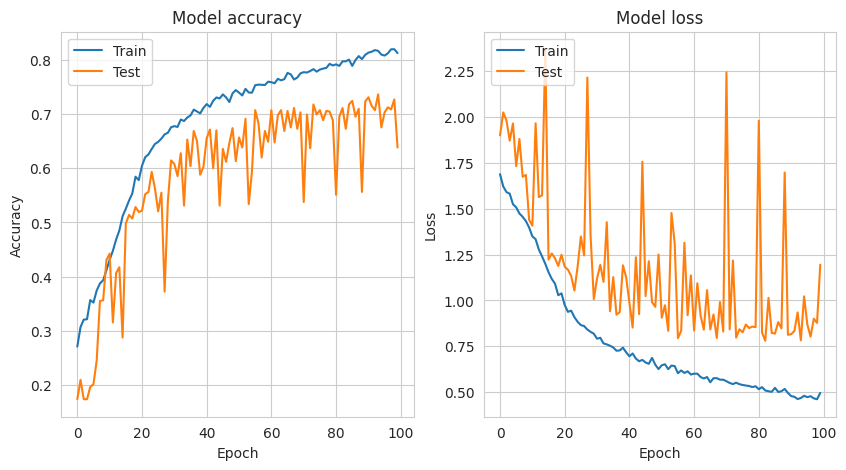

In [ ]:


import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# EfficentNetB0

In [ ]:
from tensorflow.keras import layers, models, regularizers, callbacks

def build_best_dense_model(input_shape=(242,), num_classes=6):
    inputs = layers.Input(shape=input_shape)

    x = layers.BatchNormalization()(inputs)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model = build_best_dense_model()

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[
        callbacks.EarlyStopping(patience=20, monitor='val_accuracy', restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        callbacks.ModelCheckpoint("best_dense_model.h5", save_best_only=True)
    ]
)


Epoch 1/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2143 - loss: 2.2053

95/95 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.2146 - loss: 2.2035 - val_accuracy: 0.1616 - val_loss: 1.9546 - learning_rate: 0.0010
Epoch 2/200
91/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2823 - loss: 1.8153

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2832 - loss: 1.8138 - val_accuracy: 0.2384 - val_loss: 1.8934 - learning_rate: 0.0010
Epoch 3/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3189 - loss: 1.7455

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3191 - loss: 1.7451 - val_accuracy: 0.2980 - val_loss: 1.7792 - learning_rate: 0.0010
Epoch 4/200
80/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3561 - loss: 1.6799

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3562 - loss: 1.6802 - val_accuracy: 0.3444 - val_loss: 1.6591 - learning_rate: 0.0010
Epoch 5/200
87/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3708 - loss: 1.6513

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3713 - loss: 1.6503 - val_accuracy: 0.3881 - val_loss: 1.5916 - learning_rate: 0.0010
Epoch 6/200
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3912 - loss: 1.6134

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3912 - loss: 1.6126 - val_accuracy: 0.3894 - val_loss: 1.5542 - learning_rate: 0.0010
Epoch 7/200
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4091 - loss: 1.5511

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4091 - loss: 1.5512 - val_accuracy: 0.4318 - val_loss: 1.4992 - learning_rate: 0.0010
Epoch 8/200
87/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4199 - loss: 1.5445

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4194 - loss: 1.5444 - val_accuracy: 0.4252 - val_loss: 1.4920 - learning_rate: 0.0010
Epoch 9/200
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4352 - loss: 1.5006

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4360 - loss: 1.5007 - val_accuracy: 0.4199 - val_loss: 1.4887 - learning_rate: 0.0010
Epoch 10/200
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4486 - loss: 1.4900

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4491 - loss: 1.4892 - val_accuracy: 0.4662 - val_loss: 1.4468 - learning_rate: 0.0010
Epoch 11/200
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4897 - loss: 1.4041

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4874 - loss: 1.4084 - val_accuracy: 0.4887 - val_loss: 1.4316 - learning_rate: 0.0010
Epoch 12/200
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4903 - loss: 1.4032

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4898 - loss: 1.4044 - val_accuracy: 0.4914 - val_loss: 1.4088 - learning_rate: 0.0010
Epoch 13/200
85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5008 - loss: 1.3870

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5000 - loss: 1.3884 - val_accuracy: 0.4940 - val_loss: 1.3678 - learning_rate: 0.0010
Epoch 14/200
84/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5072 - loss: 1.3796

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5070 - loss: 1.3787 - val_accuracy: 0.4993 - val_loss: 1.3393 - learning_rate: 0.0010
Epoch 15/200
85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5135 - loss: 1.3661

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5135 - loss: 1.3658 - val_accuracy: 0.5205 - val_loss: 1.3211 - learning_rate: 0.0010
Epoch 16/200
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5383 - loss: 1.3273

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5380 - loss: 1.3280 - val_accuracy: 0.5351 - val_loss: 1.3008 - learning_rate: 0.0010
Epoch 17/200
85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5306 - loss: 1.3322

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5316 - loss: 1.3300 - val_accuracy: 0.5470 - val_loss: 1.2893 - learning_rate: 0.0010
Epoch 18/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5658 - loss: 1.2667 - val_accuracy: 0.5483 - val_loss: 1.2919 - learning_rate: 0.0010
Epoch 19/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5702 - loss: 1.2792 - val_accuracy: 0.5298 - val_loss: 1.3006 - learning_rate: 0.0010
Epoch 20/200
85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5680 - loss: 1.2584

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5677 - loss: 1.2593 - val_accuracy: 0.5391 - val_loss: 1.2519 - learning_rate: 0.0010
Epoch 21/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5659 - loss: 1.2609 - val_accuracy: 0.5497 - val_loss: 1.2881 - learning_rate: 0.0010
Epoch 22/200
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5726 - loss: 1.2616

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5726 - loss: 1.2611 - val_accuracy: 0.5801 - val_loss: 1.2435 - learning_rate: 0.0010
Epoch 23/200
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5767 - loss: 1.2251

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5770 - loss: 1.2265 - val_accuracy: 0.5828 - val_loss: 1.2100 - learning_rate: 0.0010
Epoch 24/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5790 - loss: 1.2358 - val_accuracy: 0.5788 - val_loss: 1.2318 - learning_rate: 0.0010
Epoch 25/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6056 - loss: 1.1997 - val_accuracy: 0.5642 - val_loss: 1.2368 - learning_rate: 0.0010
Epoch 26/200
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6103 - loss: 1.1723

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6098 - loss: 1.1745 - val_accuracy: 0.5907 - val_loss: 1.1701 - learning_rate: 0.0010
Epoch 27/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5963 - loss: 1.2030 - val_accuracy: 0.5868 - val_loss: 1.1902 - learning_rate: 0.0010
Epoch 28/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6104 - loss: 1.1716 - val_accuracy: 0.5974 - val_loss: 1.1951 - learning_rate: 0.0010
Epoch 29/200
92/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6113 - loss: 1.2021

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6113 - loss: 1.2019 - val_accuracy: 0.6159 - val_loss: 1.1692 - learning_rate: 0.0010
Epoch 30/200
91/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6280 - loss: 1.1648

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6279 - loss: 1.1643 - val_accuracy: 0.6040 - val_loss: 1.1663 - learning_rate: 0.0010
Epoch 31/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6325 - loss: 1.1597 - val_accuracy: 0.6093 - val_loss: 1.1678 - learning_rate: 0.0010
Epoch 32/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6331 - loss: 1.1525 - val_accuracy: 0.6066 - val_loss: 1.1903 - learning_rate: 0.0010
Epoch 33/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6474 - loss: 1.1208 - val_accuracy: 0.5960 - val_loss: 1.1735 - learning_rate: 0.0010
Epoch 34/200
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6346 - loss: 1.1469

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6344 - loss: 1.1472 - val_accuracy: 0.6291 - val_loss: 1.1585 - learning_rate: 0.0010
Epoch 35/200
87/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6522 - loss: 1.1185

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6517 - loss: 1.1199 - val_accuracy: 0.6225 - val_loss: 1.1480 - learning_rate: 0.0010
Epoch 36/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6466 - loss: 1.1443 - val_accuracy: 0.6106 - val_loss: 1.1665 - learning_rate: 0.0010
Epoch 37/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6582 - loss: 1.1016 - val_accuracy: 0.6199 - val_loss: 1.1570 - learning_rate: 0.0010
Epoch 38/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6592 - loss: 1.0859 - val_accuracy: 0.6238 - val_loss: 1.1529 - learning_rate: 0.0010
Epoch 39/200
85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6483 - loss: 1.1181

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6488 - loss: 1.1176 - val_accuracy: 0.6252 - val_loss: 1.1469 - learning_rate: 0.0010
Epoch 40/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6537 - loss: 1.1062 - val_accuracy: 0.6185 - val_loss: 1.1770 - learning_rate: 0.0010
Epoch 41/200
85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6596 - loss: 1.0942

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6600 - loss: 1.0946 - val_accuracy: 0.6437 - val_loss: 1.1372 - learning_rate: 0.0010
Epoch 42/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6574 - loss: 1.1220 - val_accuracy: 0.6371 - val_loss: 1.1392 - learning_rate: 0.0010
Epoch 43/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6819 - loss: 1.0912 - val_accuracy: 0.6384 - val_loss: 1.1557 - learning_rate: 0.0010
Epoch 44/200
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6635 - loss: 1.0938

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6648 - loss: 1.0916 - val_accuracy: 0.6543 - val_loss: 1.0962 - learning_rate: 0.0010
Epoch 45/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6887 - loss: 1.0508 - val_accuracy: 0.6424 - val_loss: 1.1289 - learning_rate: 0.0010
Epoch 46/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7006 - loss: 1.0455 - val_accuracy: 0.6185 - val_loss: 1.1312 - learning_rate: 0.0010
Epoch 47/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6788 - loss: 1.0535 - val_accuracy: 0.6477 - val_loss: 1.1119 - learning_rate: 0.0010
Epoch 48/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7052 - loss: 1.0272 - val_accuracy: 0.6517 - val_loss: 1.1079 - learning_rate: 0.0010
Epoch 49/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6977 - loss: 1.0395 - val_accuracy: 0.6570 - val_loss: 1.1035 - learning_rate: 0.0010
Epoch 50/200
87/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6967 - loss: 1.0380

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6978 - loss: 1.0357 - val_accuracy: 0.6675 - val_loss: 1.0865 - learning_rate: 5.0000e-04
Epoch 51/200
85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7084 - loss: 0.9778

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7095 - loss: 0.9776 - val_accuracy: 0.6795 - val_loss: 1.0646 - learning_rate: 5.0000e-04
Epoch 52/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7345 - loss: 0.9575 - val_accuracy: 0.6755 - val_loss: 1.0769 - learning_rate: 5.0000e-04
Epoch 53/200
85/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7375 - loss: 0.9405

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7375 - loss: 0.9402 - val_accuracy: 0.6755 - val_loss: 1.0579 - learning_rate: 5.0000e-04
Epoch 54/200
87/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7459 - loss: 0.9148

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7452 - loss: 0.9167 - val_accuracy: 0.6702 - val_loss: 1.0549 - learning_rate: 5.0000e-04
Epoch 55/200
92/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7513 - loss: 0.9039

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7512 - loss: 0.9042 - val_accuracy: 0.6861 - val_loss: 1.0431 - learning_rate: 5.0000e-04
Epoch 56/200
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7470 - loss: 0.9209

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7469 - loss: 0.9208 - val_accuracy: 0.6834 - val_loss: 1.0360 - learning_rate: 5.0000e-04
Epoch 57/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7564 - loss: 0.8929 - val_accuracy: 0.6874 - val_loss: 1.0440 - learning_rate: 5.0000e-04
Epoch 58/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7664 - loss: 0.8795 - val_accuracy: 0.6834 - val_loss: 1.0466 - learning_rate: 5.0000e-04
Epoch 59/200
88/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7659 - loss: 0.8892

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7658 - loss: 0.8889 - val_accuracy: 0.6861 - val_loss: 1.0339 - learning_rate: 5.0000e-04
Epoch 60/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7631 - loss: 0.8783 - val_accuracy: 0.6927 - val_loss: 1.0380 - learning_rate: 5.0000e-04
Epoch 61/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7655 - loss: 0.8902 - val_accuracy: 0.6689 - val_loss: 1.0437 - learning_rate: 5.0000e-04
Epoch 62/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7694 - loss: 0.8503 - val_accuracy: 0.6848 - val_loss: 1.0449 - learning_rate: 5.0000e-04
Epoch 63/200
87/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7648 - loss: 0.8794

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7649 - loss: 0.8794 - val_accuracy: 0.6781 - val_loss: 1.0309 - learning_rate: 5.0000e-04
Epoch 64/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7654 - loss: 0.8597 - val_accuracy: 0.6940 - val_loss: 1.0364 - learning_rate: 5.0000e-04
Epoch 65/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7717 - loss: 0.8691 - val_accuracy: 0.6914 - val_loss: 1.0323 - learning_rate: 5.0000e-04
Epoch 66/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7845 - loss: 0.8118 - val_accuracy: 0.7020 - val_loss: 1.0371 - learning_rate: 5.0000e-04
Epoch 67/200
81/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7766 - loss: 0.8316

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7775 - loss: 0.8326 - val_accuracy: 0.7046 - val_loss: 1.0224 - learning_rate: 5.0000e-04
Epoch 68/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7885 - loss: 0.8013 - val_accuracy: 0.6874 - val_loss: 1.0416 - learning_rate: 5.0000e-04
Epoch 69/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7941 - loss: 0.8021 - val_accuracy: 0.6848 - val_loss: 1.0438 - learning_rate: 5.0000e-04
Epoch 70/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7883 - loss: 0.8195 - val_accuracy: 0.6954 - val_loss: 1.0460 - learning_rate: 5.0000e-04
Epoch 71/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7900 - loss: 0.8144 - val_accuracy: 0.6834 - val_loss: 1.0472 - learning_rate: 5.0000e-04
Epoch 72/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7987 - loss: 0.7966 - val_accuracy: 0.7033 - val_loss: 1.0381 - learning_rate: 5.0000e-04
Epoch 73/200
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7981 - loss

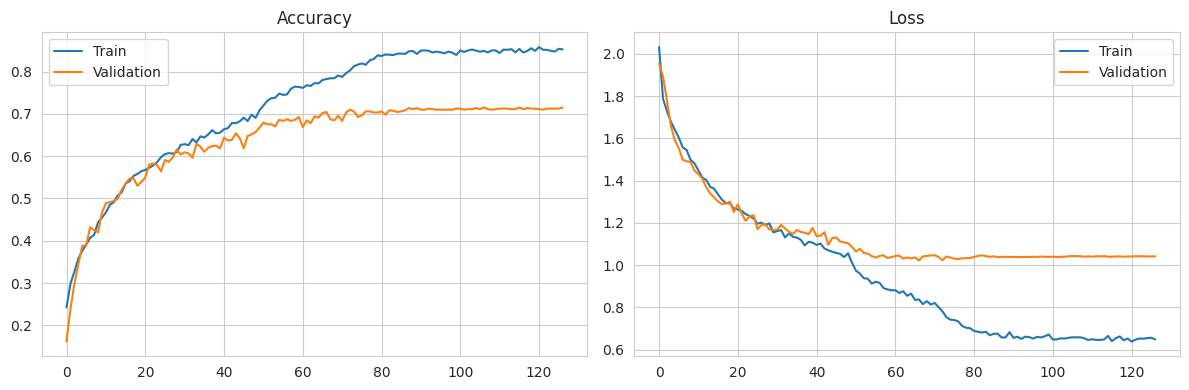

In [ ]:
# 📈 Accuracy/Loss plots
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_curves(history)


###  Diffusion Model Based on LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_diffusion_unet_with_lstm(input_shape, num_classes):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # ----- Encoder (Downsampling) -----

    # Initial Conv Block
    x = layers.Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Second Conv Block
    x = layers.Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Third Conv Block
    x = layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Bottleneck with LSTM
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(128)(x)  # This returns 2D output (batch_size, features)
    x = layers.Dropout(0.3)(x)

    # Time embedding for diffusion
    time_input = layers.Input(shape=(1,))
    time_embed = layers.Dense(128)(time_input)
    time_embed = layers.Activation('swish')(time_embed)
    time_embed = layers.Dense(128)(time_embed)

    # Combine time embedding with features
    x = layers.Dense(128)(x)
    x = x * time_embed

    # ----- Decoder (Upsampling) -----

    # Reshape to 3D for upsampling (batch_size, 1, features)
    x = layers.Reshape((1, 128))(x)

    # First upsample block
    x = layers.UpSampling1D(size=2)(x)  # Now shape is (batch_size, 2, 128)
    x = layers.Conv1D(256, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Second upsample block
    x = layers.UpSampling1D(size=2)(x)  # Now shape is (batch_size, 4, 256)
    x = layers.Conv1D(512, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Third upsample block
    x = layers.UpSampling1D(size=2)(x)  # Now shape is (batch_size, 8, 512)
    x = layers.Conv1D(1024, kernel_size=5, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Final upsample to original length
    x = layers.UpSampling1D(size=31)(x)  # 8*31=248 (close to original 242)
    x = layers.Cropping1D((3, 3))(x)     # Crop to get exactly 242 timesteps

    # Final output
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='softmax')(x)

    return Model([inputs, time_input], outputs)

# Build the model
unet_model = build_diffusion_unet_with_lstm(input_shape=(242, 1), num_classes=6)
unet_model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 242, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 242, 1024) │      6,144 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 121, 1024) │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 121, 1024) │      4,096 │ max_pooling1d_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 121, 1024) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 121, 512)  │  2,621,952 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 61, 512)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 512)   │      2,048 │ max_pooling1d_4[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 61, 512)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 61, 256)   │    655,616 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 31, 256)   │          0 │ conv1d_5[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 256)   │      1,024 │ max_pooling1d_5[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 31, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 31, 128)   │    197,120 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 31, 128)   │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 31, 128)   │    131,584 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 31, 128)   │          0 │ lstm_4[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 128)       │    131,584 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │        256 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,240,198 (27.62 MB)

 Trainable params: 7,233,030 (27.59 MB)

 Non-trainable params: 7,168 (28.00 KB)

In [ ]:
num_timesteps = 1000  # Number of diffusion timesteps
beta_start = 1e-4     # Noise schedule start
beta_end = 0.02       # Noise schedule end
betas = tf.linspace(beta_start, beta_end, num_timesteps)  # Linear noise schedule
alphas = 1. - betas
alpha_bars = tf.math.cumprod(alphas, axis=0)  # Cumulative product of alphas

In [ ]:
def add_noise(x, t):
    """Adds noise to input `x` at timestep `t`."""
    sqrt_alpha_bar = tf.sqrt(alpha_bars[t])
    sqrt_one_minus_alpha_bar = tf.sqrt(1. - alpha_bars[t])
    noise = tf.random.normal(shape=x.shape)
    return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

In [ ]:
@tf.function
def train_step(x_batch):
    # Sample random timesteps
    t = tf.random.uniform(shape=[x_batch.shape[0]], minval=0, maxval=num_timesteps, dtype=tf.int32)

    # Add noise and train
    with tf.GradientTape() as tape:
        # Vectorized add_noise
        sqrt_alpha_bar = tf.gather(tf.sqrt(alpha_bars), t)
        sqrt_one_minus_alpha_bar = tf.gather(tf.sqrt(1. - alpha_bars), t)
        noise = tf.random.normal(shape=x_batch.shape)
        x_noisy = sqrt_alpha_bar[:, None, None] * x_batch + sqrt_one_minus_alpha_bar[:, None, None] * noise
        noise_true = noise  # Assign noise_true here

        noise_pred = unet_model([x_noisy, tf.cast(t[:, None], tf.float32)], training=True) # Reshape t
        loss = tf.keras.losses.MSE(noise_true, noise_pred)

    gradients = tape.gradient(loss, unet_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, unet_model.trainable_variables))
    return loss

In [ ]:
def denoise(x, t):
    """Predicts and removes noise at timestep `t`."""
    noise_pred = unet_model([x, tf.ones((x.shape[0], 1)) * t], training=False)  # Output shape should be (batch_size, 242, 1)
    sqrt_alpha_bar = tf.sqrt(alpha_bars[t])
    sqrt_one_minus_alpha_bar = tf.sqrt(1. - alpha_bars[t])
    return (x - sqrt_one_minus_alpha_bar * noise_pred) / sqrt_alpha_bar


In [ ]:
def generate(num_samples=1):
    """Generates samples from noise."""
    x = tf.random.normal(shape=(num_samples, 242, 1))  # Start from random noise

    for t in reversed(range(num_timesteps)):
        x = denoise(x, t)
        if t > 0:
            z = tf.random.normal(shape=x.shape)  # Add noise for next step
            x += tf.sqrt(betas[t]) * z

    # The U-Net model output should already have 1 channel
    # x = x[:, :, 0:1]  # Remove this line

    return x

In [ ]:
# Extract features using the last LSTM layer before the dense decoder
encoder = tf.keras.Model(
    inputs=unet_model.input[0],  # Use the first input only (probably mel-spectrogram)
    outputs=unet_model.get_layer("lstm_5").output
)

# Extract features from training data
features = encoder.predict(x_train)  # Shape: (num_samples, timesteps, features)

# Classifier head
classifier = tf.keras.Sequential([
    tf.keras.layers.Flatten(),  # Convert 3D to 2D
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')  # 6 emotion classes
])

# Compile and train the classifier
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.fit(features, y_train, epochs=10)


189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1936 - loss: 1.7861
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2132 - loss: 1.7766
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2146 - loss: 1.7774
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2099 - loss: 1.7763
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2100 - loss: 1.7775
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2048 - loss: 1.7767
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2105 - loss: 1.7787
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2061 - loss: 1.7769
Epoch 9/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2130 - loss: 1.7740
Epoch 10/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2027 - loss: 1.7802
